**Cargar librerias**

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import scipy as sc
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display
import sys

**Metricas**

In [2]:
from sklearn.metrics import roc_curve, auc
import sklearn as sk

    
def AMSScore(s,b): 
    return np.sqrt (2.*( (s + b + 10.)*np.log(1.+s/(b+10.))-s))

def eval_model(Y_true_train,Y_pred_train,w_train,Y_true_test,Y_pred_test,w_test):
    ratio =  float(len(X_train)) /float(len(X_test))
    TruePositive_train = w_train*(Y_true_train==1.0)*(1.0/ratio)
    TrueNegative_train = w_train*(Y_true_train==0.0)*(1.0/ratio)
    TruePositive_valid = w_test*(Y_true_test==1.0)*(1.0/(1-ratio))
    TrueNegative_valid = w_test*(Y_true_test==0.0)*(1.0/(1-ratio))
    s_train = sum ( TruePositive_train*(Y_pred_train==1.0) )
    b_train = sum ( TrueNegative_train*(Y_pred_train==1.0) )
    s_test = sum ( TruePositive_valid*(Y_pred_test==1.0) )
    b_test = sum ( TrueNegative_valid*(Y_pred_test==1.0) )
    score_train = AMSScore(s_train,b_train)
    score_test = AMSScore(s_test,b_test)
    print('--- Resultados --')
    print('- AUC train: {:.3f} '.format(sk.metrics.roc_auc_score(Y_train,Y_train_pred)))
    print('- AUC test : {:.3f} '.format(sk.metrics.roc_auc_score(Y_test,Y_test_pred)))
    print('- AMS train: {:.3f} sigma'.format(score_train))
    print('- AMS test : {:.3f} sigma'.format(score_test))
    return score_train, score_test

def plot_roc(clf,Y_test,Y_test_prob):
    fpr, tpr, thresholds = roc_curve(Y_test, Y_test_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=str(clf.__class__.__name__))
    plt.plot(np.linspace(0,1,100),np.linspace(0,1,100), lw=2, alpha=0.3, label='Suerte')
    plt.legend(loc='lower right')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.tight_layout()
    return

**Datos**

In [3]:
# !wget https://raw.githubusercontent.com/beangoben/RIIAA_Escuela18/master/datos/training.csv

df=pd.read_csv('C:\\Users\\tkalnik\\PycharmProjects\\RIIAA_Escuela18-master\\datos\\training.csv')
print(df.shape)
df.head(1)

(250000, 33)


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.47,51.655,97.827,27.98,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.15,0.444,46.062,1.24,-2.475,113.497,0.002653,s


**Preprocesamiento para X y Y**

Utilicé random_state para que en la division de los set se seleccionen los elementos de los grupos de forma aleatoria.

In [4]:
Y = df['Label'].replace(to_replace=['s','b'],value=[1,0]).values
weights = df['Weight'].values
X = df.drop(['EventId','Label','Weight'],axis=1).values



In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test,w_train,w_test = train_test_split(X,Y,weights,random_state=42,train_size=0.3)
print(X_train.shape,Y_train.shape,w_train.shape)
print(X_test.shape,Y_test.shape,w_test.shape)

(75000, 30) (75000,) (75000,)
(175000, 30) (175000,) (175000,)


C:\Users\tkalnik\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


**ML con SKLearn**

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

f = [('escalar', StandardScaler()),('classifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]

pipeline = Pipeline(f)
pipeline.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('escalar', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

**Predicciones**

In [12]:
Y_train_pred = pipeline.predict(X_train)
Y_test_pred = pipeline.predict(X_test)
Y_train_prob=pipeline.predict_proba(X_train)[:,1]
Y_test_prob =pipeline.predict_proba(X_test)[:,1]




C:\Users\tkalnik\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\tkalnik\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


**Punto de corte**

C:\Users\tkalnik\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


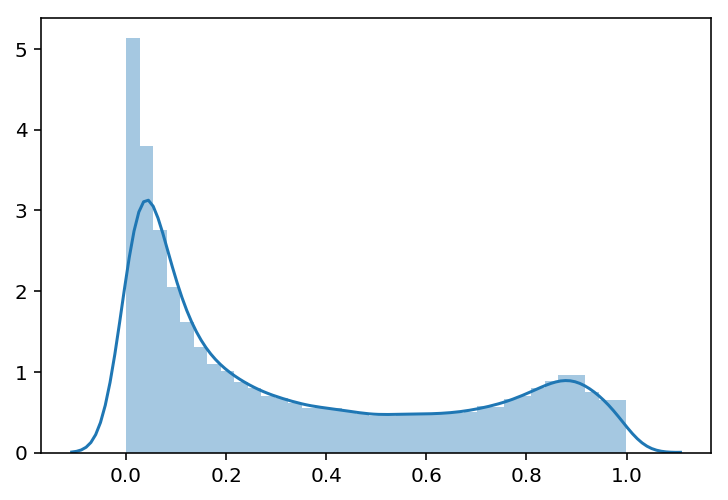

0.8127681761980057

In [13]:
sns.distplot(Y_train_prob)
plt.show()
pcut = np.percentile(Y_train_prob,85)
pcut

In [14]:
Y_train_pred = Y_train_prob > pcut 
Y_test_pred = Y_test_prob > pcut


eval_model(Y_train,Y_train_pred,w_train,Y_test,Y_test_pred,w_test)

--- Resultados --
- AUC train: 0.694 
- AUC test : 0.690 
- AMS train: 3.026 sigma
- AMS test : 3.732 sigma


(3.02559365301972, 3.7315404851499703)

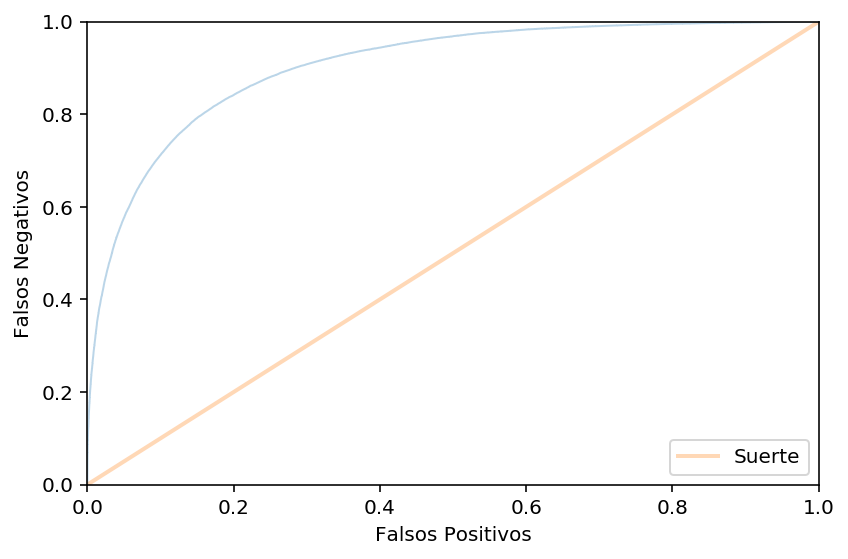

In [15]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_test, Y_test_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.3, label=str(''))
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100), lw=2, alpha=0.3, label='Suerte')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Falsos Positivos')
plt.ylabel('Falsos Negativos')
plt.tight_layout()
plt.show()